# Production notebook

In [1]:
#TODO: delete cell
##enables reload of modules 
%load_ext autoreload
%autoreload 2

In [2]:
import os 
import sys
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import *
#custom utilities: 
parent_directory = os.path.abspath('..')
sys.path.append(parent_directory)
from utils import config
from utils.config import *
from utils import datawrangler
from utils.preflight import *
from utils.plotstyle import *
from utils.production import *
initialize_custom_style()

In [3]:
##configurable stuff: read the file, asign it to variables: 
root_dir = config.get_root_dir()
config_dict = config.readconfig(os.path.join(root_dir, 'config/config_production.json'))
data_dir = os.path.join(root_dir, config_dict['data_dir'])
print(config_dict)

{'data_dir': 'data/rawdata/full/data_productie', 'masterfile': 'master_data.json', 'dailydirname': 'daily_production'}


## reading data in Python:

In [4]:

#load all the data required for this task. 
#masterfile
master_production_data= pd.read_json(os.path.join(root_dir, config_dict['data_dir'], config_dict['masterfile']), typ='series')
production_data = pd.DataFrame(load_json_datafiles(os.path.join(root_dir, config_dict['data_dir'], config_dict['dailydirname'])))

## Inspecting read data

In [5]:
preflightchecks(production_data)
#not that great, but:
#   we learned that not a single column is truely unique!
#   maintainece is to be considered a boolean.
#   some values that should be ints, are objects! Why? 


,Column Name,Data Type,NaN Count,Unique Count,suitable PK,Max,Min,Range,Avg,Median,Mode,Standard Dev,Variance,Skewedness,Kurtosis,Quant_25,Quant_50,Quant_75,Out of bound lows,Out of bound highs
0,DoW,object,0,7,False,NaN,NaN,NaN,NaN,NaN,Monday,NaN,NaN,NaN,NaN,None,None,None,None,None
1,hour,int64,0,1,False,1.0,1.0,0.0,1.0,1.0,1,0.0,0.0,0.0,0.0,"0.25 1.0 Name: hour, dtype: float64","0.5 1.0 Name: hour, dtype: float64","0.75 1.0 Name: hour, dtype: float64",None,None
2,minute,int64,0,1,False,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,"0.25 0.0 Name: minute, dtype: float64","0.5 0.0 Name: minute, dtype: float64","0.75 0.0 Name: minute, dtype: float64",None,None
3,date,object,0,1830,False,NaN,NaN,NaN,NaN,NaN,01-01-2018 00:00:00.0000,NaN,NaN,NaN,NaN,None,None,None,None,None
4,maintenance,object,0,2,False,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,None,None,None,None,None
5,prod_loss,object,0,434,False,NaN,NaN,NaN,NaN,NaN,1244,NaN,NaN,NaN,NaN,None,None,None,None,None
6,prod_loss_perc,object,0,94,False,NaN,NaN,NaN,NaN,NaN,100,NaN,NaN,NaN,NaN,None,None,None,None,None
7,production,object,0,581,False,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,None,None,None,None,None
8,sourcefile,object,0,1830,False,NaN,NaN,NaN,NaN,NaN,20180101.json,NaN,NaN,NaN,NaN,None,None,None,None,None
9,facility,object,0,2,False,NaN,NaN,NaN,NaN,NaN,BRU,NaN,NaN,NaN,NaN,None,None,None,None,None


In [6]:
#drop data for days where there's maintenance:
production_data_no_maintenance = production_data.query("maintenance == 'No'").copy()
#convert columns to ints where appropriate:
to_int_columns = ['prod_loss', 'prod_loss_perc', 'production']
for col in to_int_columns: 
    production_data_no_maintenance[col] = production_data_no_maintenance[col].astype('int')
    

In [7]:
preflightchecks(production_data_no_maintenance)

,Column Name,Data Type,NaN Count,Unique Count,suitable PK,Max,Min,Range,Avg,Median,Mode,Standard Dev,Variance,Skewedness,Kurtosis,Quant_25,Quant_50,Quant_75,Out of bound lows,Out of bound highs
0,DoW,object,0,7,False,NaN,NaN,NaN,NaN,NaN,Monday,NaN,NaN,NaN,NaN,None,None,None,None,None
1,hour,int64,0,1,False,1.0,1.0,0.0,1.000000,1.0,1,0.000000,0.000000,0.000000,0.000000,"0.25 1.0 Name: hour, dtype: float64","0.5 1.0 Name: hour, dtype: float64","0.75 1.0 Name: hour, dtype: float64",None,None
2,minute,int64,0,1,False,0.0,0.0,0.0,0.000000,0.0,0,0.000000,0.000000,0.000000,0.000000,"0.25 0.0 Name: minute, dtype: float64","0.5 0.0 Name: minute, dtype: float64","0.75 0.0 Name: minute, dtype: float64",None,None
3,date,object,0,1830,False,NaN,NaN,NaN,NaN,NaN,01-01-2018 00:00:00.0000,NaN,NaN,NaN,NaN,None,None,None,None,None
4,maintenance,object,0,1,False,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,None,None,None,None,None
5,prod_loss,int32,0,433,False,1244.0,9.0,1235.0,264.636443,159.0,1244,326.334440,106494.166542,2.344464,4.342576,"0.25 73.0 Name: prod_loss, dtype: float64","0.5 159.0 Name: prod_loss, dtype: float64","0.75 274.0 Name: prod_loss, dtype: float64",None,None
6,prod_loss_perc,int32,0,93,False,100.0,3.0,97.0,35.002028,25.0,100,27.561186,759.618947,1.645627,1.232245,"0.25 20.0 Name: prod_loss_perc, dtype: float64","0.5 25.0 Name: prod_loss_perc, dtype: float64","0.75 32.0 Name: prod_loss_perc, dtype: float64",None,None
7,production,int32,0,580,False,1193.0,0.0,1193.0,497.173523,215.0,0,424.405019,180119.620127,0.343864,-1.690923,"0.25 191.0 Name: production, dtype: float64","0.5 215.0 Name: production, dtype: float64","0.75 974.0 Name: production, dtype: float64",None,None
8,sourcefile,object,0,1830,False,NaN,NaN,NaN,NaN,NaN,20180101.json,NaN,NaN,NaN,NaN,None,None,None,None,None
9,facility,object,0,2,False,NaN,NaN,NaN,NaN,NaN,BRU,NaN,NaN,NaN,NaN,None,None,None,None,None


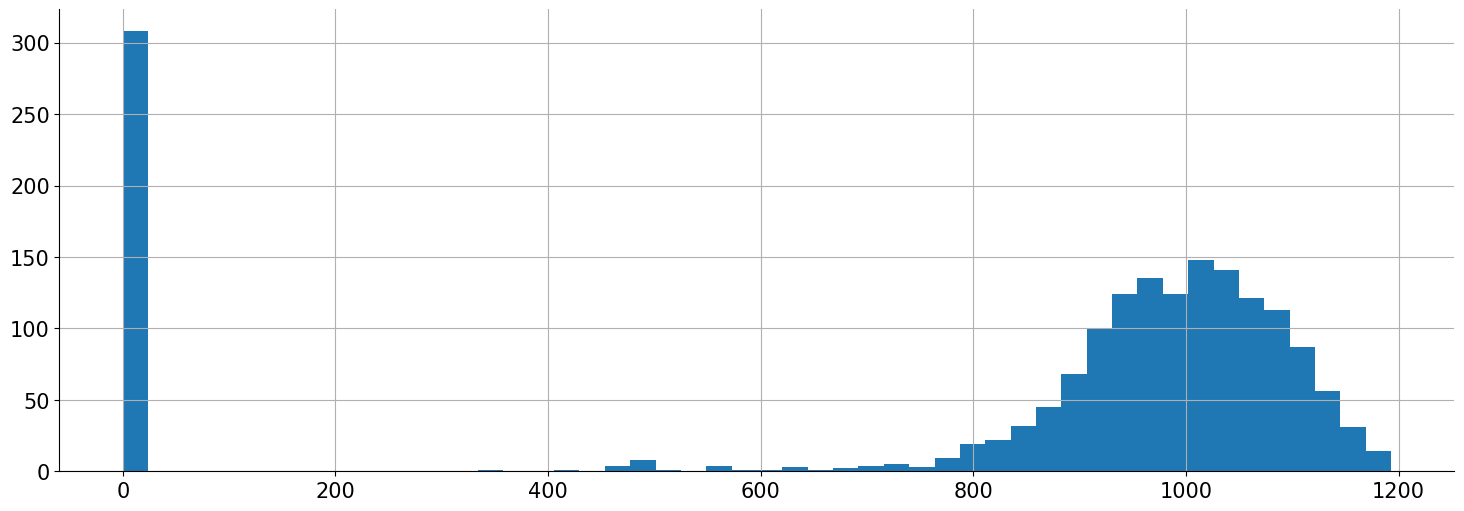

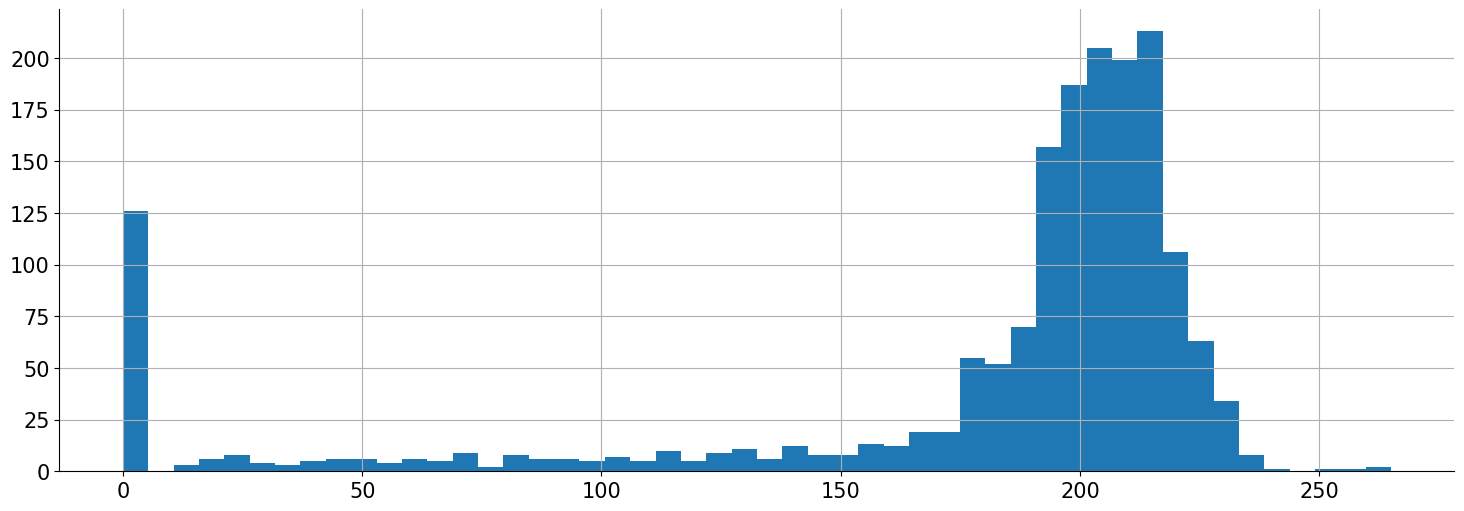

In [8]:
#what's the chance of NO PRODUCITON per facility IGNORING maintenance: 
no_production_chance = {}
for facility, group in production_data_no_maintenance.groupby('facility'): 
    no_production_chance[facility] = group.query('production == 0').shape[0]/group.query('production > 0').shape[0]
    #to have an idea of what we should be targetting in our data: 
    group.production.hist(bins= 50)
    plt.show()


In [9]:

no_production_days = production_data_no_maintenance.query("production == 0")
production_days = production_data_no_maintenance.query("production > 0")

In [10]:
no_production_days

,DoW,hour,minute,date,maintenance,prod_loss,prod_loss_perc,production,sourcefile,facility
24,Thursday,1,0,01-25-2018 00:00:00.0000,No,1244,100,0,20180125.json,BRU
25,Friday,1,0,01-26-2018 00:00:00.0000,No,1244,100,0,20180126.json,BRU
26,Saturday,1,0,01-27-2018 00:00:00.0000,No,1244,100,0,20180127.json,BRU
27,Sunday,1,0,01-28-2018 00:00:00.0000,No,1244,100,0,20180128.json,BRU
37,Wednesday,1,0,02-07-2018 00:00:00.0000,No,1244,100,0,20180207.json,BRU
...,...,...,...,...,...,...,...,...,...,...
3498,Wednesday,1,0,07-27-2022 00:00:00.0000,No,274,100,0,20220727.json,STO
3499,Thursday,1,0,07-28-2022 00:00:00.0000,No,274,100,0,20220728.json,STO
3500,Friday,1,0,07-29-2022 00:00:00.0000,No,274,100,0,20220729.json,STO
3501,Saturday,1,0,07-30-2022 00:00:00.0000,No,274,100,0,20220730.json,STO


In [12]:
predictions_per_facility = {}
for facility, group in production_days.groupby('facility'): 
    predictions_per_facility[facility] = norm.fit(group['production'])


In [13]:
def simulate(facilitycode, n_days): 
    production = []
    delta = 10 ** -6
    for day in range(n_days): 
        #get the chance of total failure at facility:
        catastrophe = no_production_chance[facilitycode]
        chance_of_catastrophe = np.random.rand() 
        if catastrophe - chance_of_catastrophe > delta:
            #total fuck up :)
            production.append(0)
        else:
            mean, stdev = predictions_per_facility[facilitycode]
            result_of_scipy = norm.rvs(loc=mean, scale=stdev, size=1)[0]
            production.append(result_of_scipy)
    return production


brures = simulate('BRU', 100000)
stores = simulate('STO', 100000)


In [15]:
#cool, brures and stores have a predicted fuck up rate that is close enough
#to the actual fuck up rates! so that part is good enough.
print(brures.count(0)/100000)
print(stores.count(0)/100000)


0.21631
0.08072


<Axes: ylabel='Frequency'>

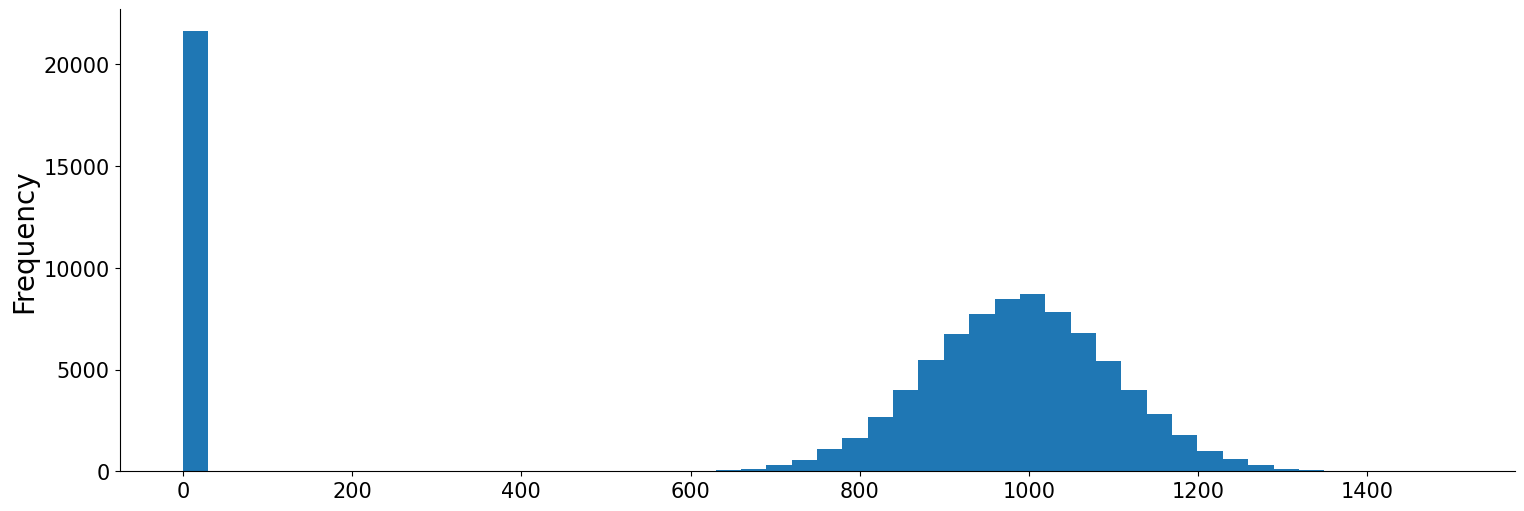

In [16]:

pd.Series(brures).plot.hist(bins =50)

<Axes: ylabel='Frequency'>

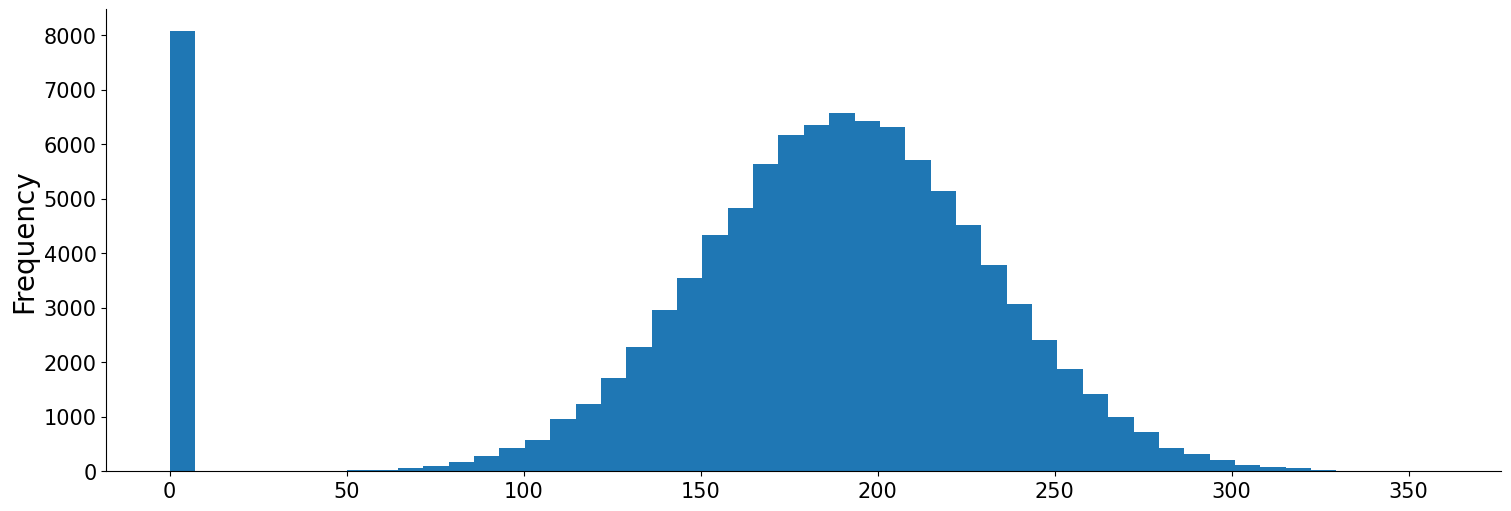

In [17]:
pd.Series(stores).plot.hist(bins =50)

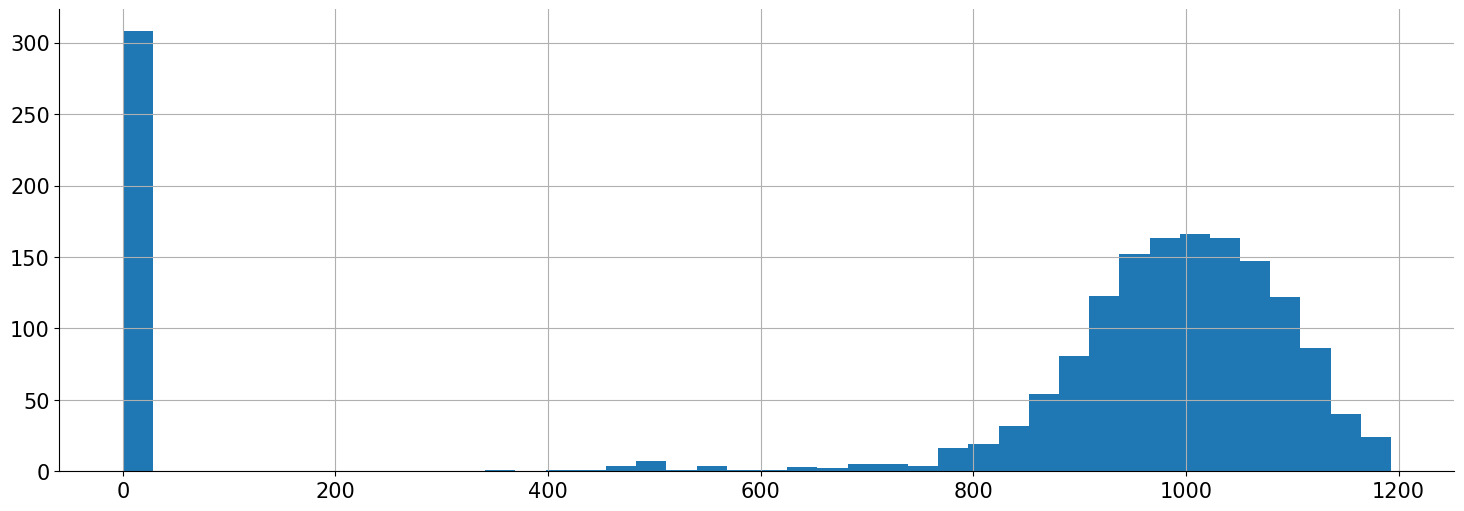

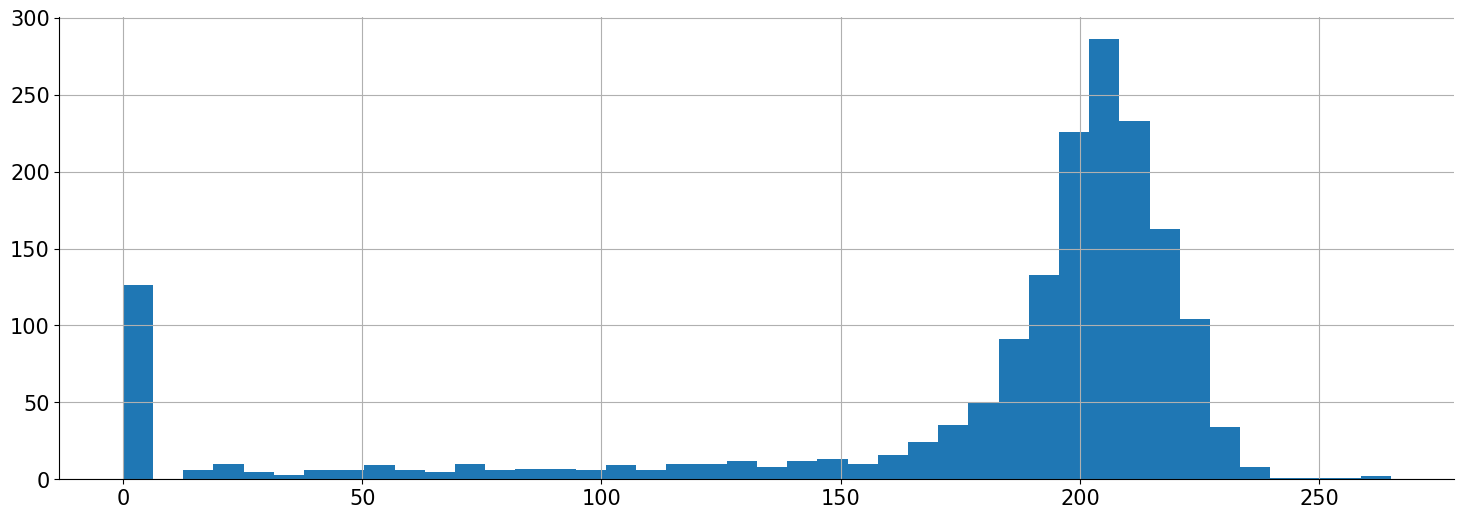

In [18]:
for facility, group in production_data_no_maintenance.groupby('facility'):
    group.production.hist(bins = int(np.ceil(np.sqrt(group.shape[0]))))
    plt.show()

## DEEL 7

[    0.           204.08163265   408.16326531   612.24489796
   816.32653061  1020.40816327  1224.48979592  1428.57142857
  1632.65306122  1836.73469388  2040.81632653  2244.89795918
  2448.97959184  2653.06122449  2857.14285714  3061.2244898
  3265.30612245  3469.3877551   3673.46938776  3877.55102041
  4081.63265306  4285.71428571  4489.79591837  4693.87755102
  4897.95918367  5102.04081633  5306.12244898  5510.20408163
  5714.28571429  5918.36734694  6122.44897959  6326.53061224
  6530.6122449   6734.69387755  6938.7755102   7142.85714286
  7346.93877551  7551.02040816  7755.10204082  7959.18367347
  8163.26530612  8367.34693878  8571.42857143  8775.51020408
  8979.59183673  9183.67346939  9387.75510204  9591.83673469
  9795.91836735 10000.        ]
ECDFResult(cdf=EmpiricalDistributionFunction(quantiles=array([    0.        ,   204.08163265,   408.16326531,   612.24489796,
         816.32653061,  1020.40816327,  1224.48979592,  1428.57142857,
        1632.65306122,  1836.73469388,  

ValueError: x and y must have same first dimension, but have shapes (50,) and (1,)

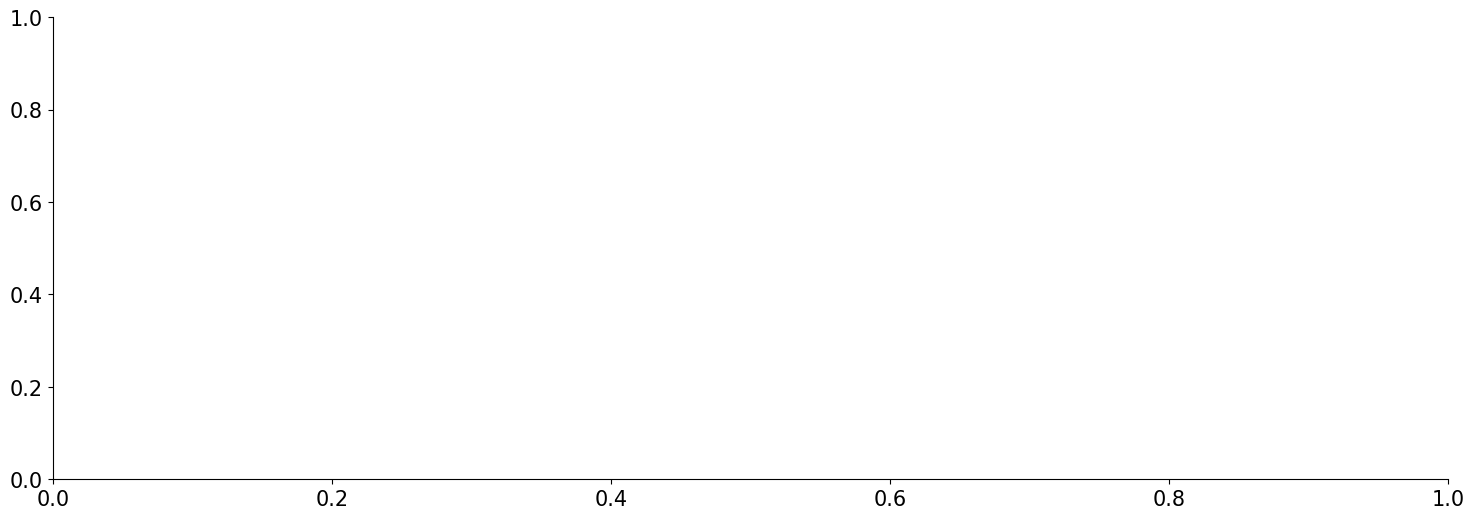

In [20]:
xx = np.linspace(0, 10 ** 4)
data = simulate('BRU', 7)
Fxx = ecdf(xx)
print(xx)
print(Fxx)
plt.plot(xx, Fxx)

## Central Limit Theoream   

In [21]:
brures_large = simulate('BRU', 1000000)
stores_large = simulate('STO', 1000000)

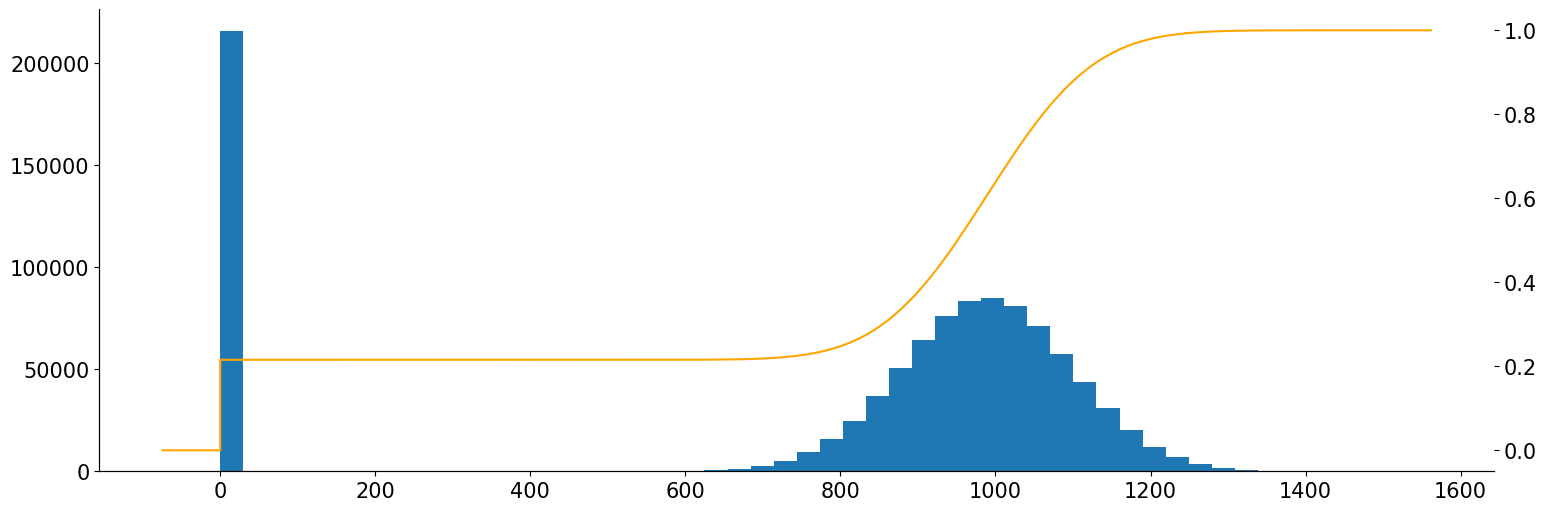

In [25]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.hist(
    brures_large, 
    bins=50
    )

ecdf(brures_large).cdf.plot(ax2, color='orange')

# pd.Series(brures_large).plot.hist(bins =50)
# brures_large_ecdf = 

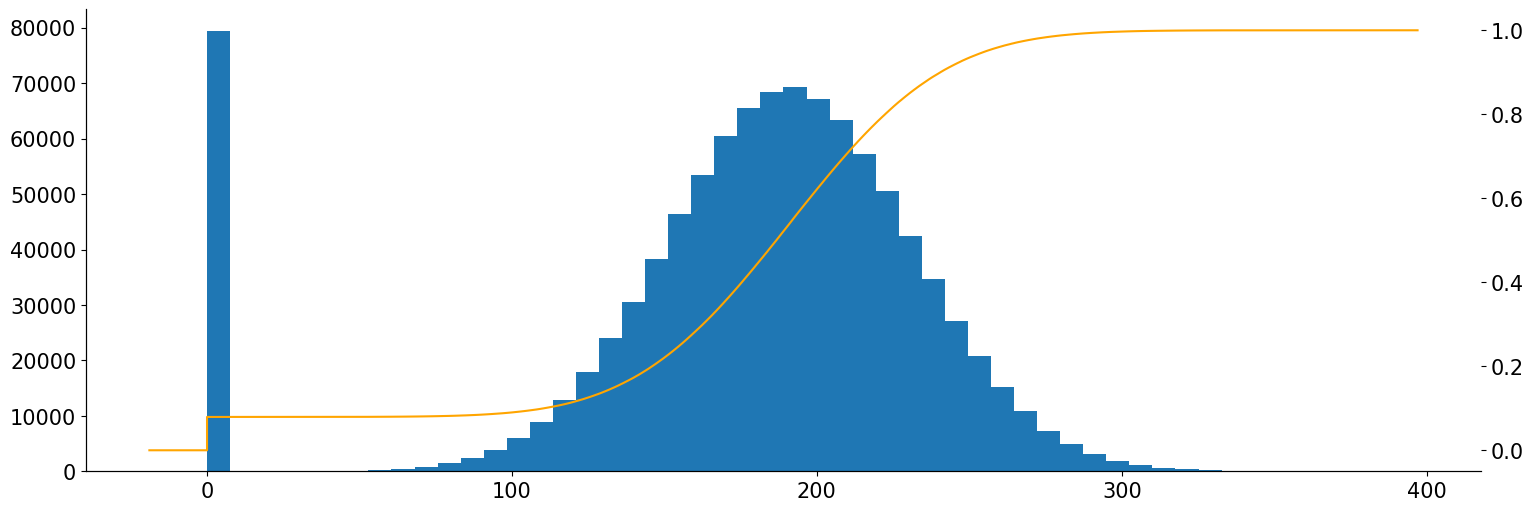

In [26]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.hist(
    stores_large, 
    bins=50
    )

ecdf(stores_large).cdf.plot(ax2, color='orange')